# ANALYSIS 2 - Traveling Salesman Problem (TSP)

In this notebook we present the traveling salesman problem (TSP). How to encode the data and plot it with matplotlib, as well as how to solve it. First, we investigate the brute-force approach using combinatorics to list all possible solutions and find the best one. Then we apply the same approach on a real case locations in Rotterdam. Finally, we show how to use probabilistic optimization to tackle TSP with larger number of cities.

The TSP presented here is a generic one, but the concept is widely applicable in many different fields, with minor modifications.

This document contains:
- [Traveling salesman problem](#intro)
- [Preparing and plotting data](#prepare)
- [Trip and trip plotting](#trip)
- [Calculating distance (Euclidean)](#edistance)
- [Solving TSP](#brute)
- [TSP Rotterdam](#rotterdam)
- [Haversine distance](#haversine)
- [The shortest path in Rotterdam](#alltogether)
- [Travelling in circles](#circle)
- [Probabilistic optimisation](#opt)


<a id='intro'></a>
## Traveling salesman problem

The __traveling salesman problem (TSP)__ is one of the most researched problems in computational mechanics. For given a) __list of cities (locations)__ and b) __the distances between those__, __TSP__ is about: (i) ___finding the shortest possible route___, so that (ii) ___each city is visited exactly once___, and then (iii) ___return to the city of origin (starting point)___.

__TSP__ falls into a category of [NP hard](https://en.wikipedia.org/wiki/NP-hardness) problems, which have the characteristic that the algorithm exponentially increases with the addition of every single input element. Many common business problems, such as [vehicle routing problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem) are generalizations of __TSP__, and as such studied as part of _combinatorial optimization_, taught by _computer science_ and _operation research_ courses.

More info on __TSP__ can be found on [Wikipedia: TSP](https://en.wikipedia.org/wiki/Travelling_salesman_problem). [University of Waterloo](http://www.math.uwaterloo.ca/tsp/index.html) also has a page dedicated to this topic with lots of useful resources.


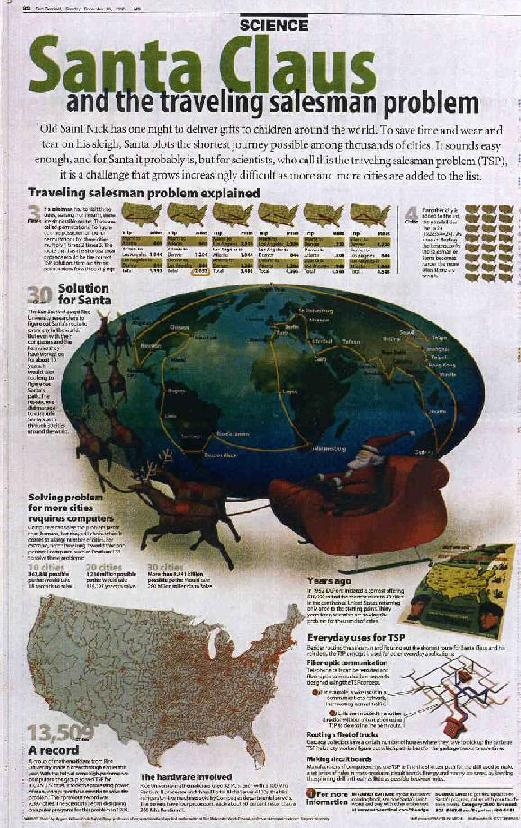
<center>(Source: The Florida Sun-Sentinel, 20 December 1998; taken from: http://www.math.uwaterloo.ca/tsp)</center>

<a id='prepare'></a>
## Preparing and plotting data

Let us begin by deciding on a data structure. We will use points to represent cities. Each point can be represented on Cartesian coordinate system, with (x, y) coordinate pair. Therefore, each city will be a tuple consisting of x-coordinate, y-coordinate and a name. All cities can be stored as part of a list, or tuple for faster computation.

In [ ]:
cities = ((1, 5, "A"), (2, 1, "B"), (9, 10, "C"), (2,10, "D"),
            (5, 4, "E"), (8, 6, "F"), (6, 9, "G"), (10, 1, "H"),
            )

Import pyplot.

In [ ]:
import matplotlib.pyplot as plt

We can plot those right away, but it is a good practice to make some helper function for easier use.

In [ ]:
def setup_plot(cities):
    """ creates a new plot and sets axes """ 
    plt.subplots(figsize = (8,7))
    x_right = max(cities,key=lambda t: t[0])[0] + 1
    y_top = max(cities,key=lambda t: t[1])[1] + 1
    plt.axis([0, x_right,0, y_top])
    

def write_text(x, y, text, Xoffset = 0, Yoffset = 0, font_size = 12):
    """ Writes given text (str) at given (x,y) coordinates """
    plt.text(x+Xoffset,y+Yoffset,text, horizontalalignment='center', size=font_size)
    

def plot_cities(cities):
    """ plots given cities; expects each city to have (x,y,"name") """
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.plot(x,y, "bo")

    for city in cities:
        write_text(city[0], city[1], city[2], Xoffset = 0.1, Yoffset = 0.3)

Call the functions to plot given cities. Feel free to alter the data.

In [ ]:
setup_plot(cities)
plot_cities(cities)

<a id='trip'></a>
## Trip and trip plotting

A trip can be represented as a sequence of number, where each number represents a city and the sequence the order in which they are visited. For example: (1, 5, 2, 4, 3) would mean that the trip starts at city 1, then the salesman visits city 5, then 2, following by 4 and 3. Of course, __TSP__ assumes that at the end we return to the city of origin, in this case city 1.

In Python, this can be represented as a list of integers, but we can also opt to use the same data structure that describes cities (tuple containing x, y and label) to encode city information. For simplicity, we will go with this option.

Let us begin with a naive trip that will visit all the cities in the order they are given. That is: A, B, C, D, E, F, G, H and then return to A. We will refer to it as `naive_trip`.

In [ ]:
naive_trip = cities

We can add one more helper function to make a round trip by adding the first city to the list / tuple as the last, too.

In [ ]:
def make_round_trip(trip):
    """ appends the first element of the trip as the last """
    return trip[:] + trip[:1]

Finally, implement `plot_path` to display lines connecting the cities in the order they are visited.

Note: we call the function `plot_path` and not `plot_trip` as later we will improve upon this one and want to distinguish them by giving them different names.

In [ ]:
def plot_path(trip, round_trip = True):
    """ plots the given trip by connecting cities with lines """
    if round_trip:
        trip = make_round_trip(trip)

    x = [point[0] for point in trip]
    y = [point[1] for point in trip]
    plt.plot(x,y, "g-")

    plt.plot(x[0],y[0], 'rD')

Use the available functions to plot cities and our `naive_trip`.

In [ ]:
# naive_trip = cities        # repeated in case the cell assigning this value was not executed

setup_plot(cities)
plot_cities(cities)
plot_path(naive_trip)

For testing (debugging) purposes, you can also print the trip.

In [ ]:
print(naive_trip)

Or, you can filter out the coordinates by printing only point labels.

In [ ]:
print(tuple(map(lambda t: t[2], naive_trip)))

<a id='edistance'></a>
## Calculating distance - Euclidean distance

Our naive_trip is not the best option. This can be determined visually, as solutions where paths cross are never optimal, i.e. there is a guaranteed better solution. But, we need to have a measure to determine how good (or bad) a solution is, and to compare it with others. To do this, we need to calculate the distance between the points. In Cartesian coordinate system, we can use __Euclidean distance__.

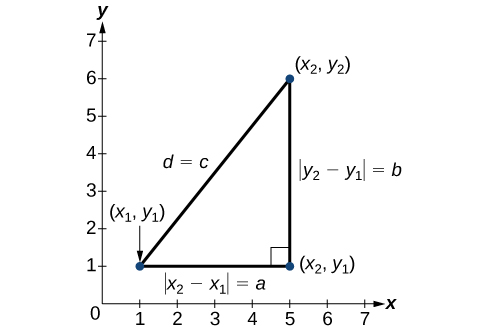
<center>(Image source: https://courses.lumenlearning.com/ )</center>

In 2D space, Pythagorean theorem can be applied to calculate the distance ___d___ between points ___p___ and ___q___. Let ___p___ have coordinates _(p<sub>1</sub>, p<sub>2</sub>)_ and ___q___ have coordinates _(q<sub>1</sub>, q<sub>2</sub>)_. Then, the distance ___d___ is:
$$d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2}$$

In [ ]:
from math import sqrt

In [ ]:
def city_distance(point1, point2):
    """ returns eucledian distance between two points """
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    return sqrt(dy**2 + dx**2)

The function `get_trip_length()` will be our workhorse function. To make it more versatile, we make it accept distance function as a parameter.

In [ ]:
def get_trip_length(trip, dist_function = city_distance, round_trip = True):
    """ calculates and returns the trip length using given distance function """
    # if less than two points are given, return special value
    if len(trip) < 2:
        return -1

    # adjust for round trip if needed
    if round_trip:
        trip = make_round_trip(trip)

    # loop through all points, get pairs, sum their distances
    result = 0
    for i in range(len(trip)-1):
        segment_length = dist_function(trip[i], trip[i+1])
        result += segment_length
    return result

Use `get_trip_length()` the find out the length of `naive_trip`.

In [ ]:
get_trip_length(naive_trip)

### Experimenting with trips

To test the function we made so far, and see how the problem behaves with different trips, let us create some, check their lengths and plot them.

In [ ]:
def create_trip(cities, order):
    """ create trip data (tuple) using the order given by the user """

    # check for mistakes like visiting a city more than once,
    # or asking for more points than exist in the data set
    if len(order) > len(cities) or len(set(order)) != len(order):
        return None
    
    trip = [cities[point-1] for point in order]
    return tuple(trip)
    

Pick a new trip. For example, try to visit the cities in the following order: 3, 1, 2, 8, 5, 4, 6, 7. Find its length.

Change the trip later to include any other order.

In [ ]:
new_trip = create_trip(cities, (3,1,2,8,5,4,6,7))
sub_trip = create_trip(cities, (2,8,5))

print("new trip length:", get_trip_length(new_trip))
print("sub trip length:", get_trip_length(sub_trip))

Visualize new trips with matplotlib.

In [ ]:
setup_plot(cities)
plot_cities(cities)
plot_path(new_trip)

<a id='brute'></a>
## Solving TSP
#### Optimal trip (the shortest length) using permutations

In the introduction we mentioned that **TSP** is NP-hard problem. Therefore, for large number of cities, brute force approach will not suffice. Yet, for small ones, our computers can cope. The brute force algorithm will try every possible trip, calculate the length of each, and save the one with the smallest value.

If we look at the problem in more detail, we can determine that all possible trips are just sequences of numbers, where the order matters and where the values cannot repeat. This is what we learned in combinatorics as permutations. Knowing this, we can let Python and itertools module do the work.

Note: if you are not familiar with the workings of the itertools module, check itertools reader.

In [ ]:
from itertools import permutations

Encode all trips.

In [ ]:
trips = tuple(permutations(cities, r=len(cities)))

Test the output. We know this is a permutation on the entire list. Therefore, there will be `n!` trips. In our case, with 8 cities, it should be 8! = 40320.

In [ ]:
len(trips)

Printing all trips is not convenient (although you can try), so we will sample few. Feel free to experiment and plot them.

In [ ]:
print(trips[42])
print(trips[100])
print(trips[30000])

Let us find the best one - the one with the smallest distance. For easier processing later, we will create another list, of the same dimension and length as `trips` and store each distance there. 

In [ ]:
def list_lengths(trips, dist_function = city_distance, round_trip = True):
    """ create a list holding distance for each of the given trips """
    return [get_trip_length(t, dist_function, round_trip) for t in trips]

In [ ]:
distances = list_lengths(trips)

All that is left to be done is find the index with the smallest trip length.

In [ ]:
best_idx = distances.index(min(distances))
best_trip = trips[best_idx]

print(best_trip)
print(get_trip_length(best_trip))

Plot it to find out how it looks like.

In [ ]:
setup_plot(cities)
plot_cities(cities)
plot_path(best_trip)

<a id='rotterdam'></a>
## TSP Rotterdam

For the next example, we have downloaded the road map containing Rotterdam's city center and surroundings. TSP will be used to find the optimal path for the selected locations in the city. For simplicity, aerial distance will be used. Although, this can be altered by adding a table containing distances in kilometers for every location pair.

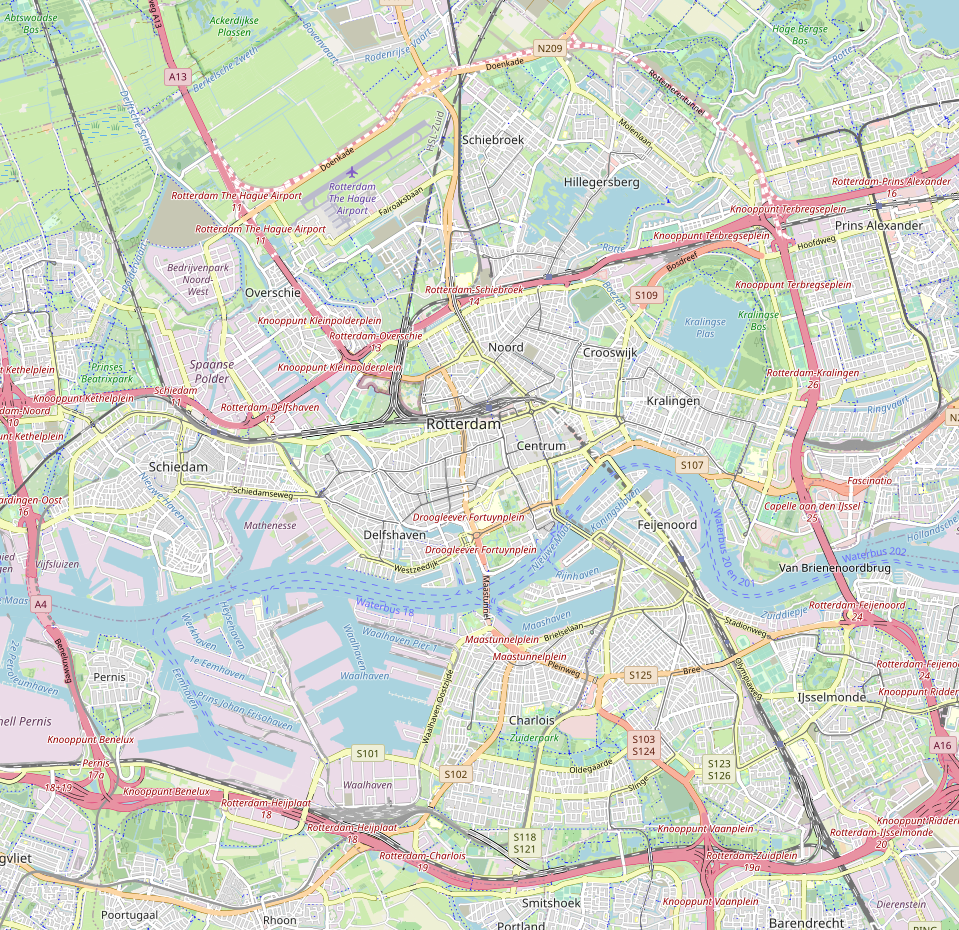

Pyplot can easily load images and plot on top of those. Function `plot_map()` loads map image from a given file, uses bounding box to set proper latitude and longitude on the axes and then plots it.

In [ ]:
def plot_map(map_file, BBox):
    tsp_map = plt.imread(map_file)
    ax = plt.gca()

    ax.imshow(tsp_map, zorder=0, extent = BBox, aspect='auto')

You can right-click on the map above, and save it as `map.png`. Then, set the path to the folder where you saved the file and call `plot_map()`.

Note: The cell below will **not work** in Jupyter!

In [ ]:
# Mac
# map_path = "/Users/../../map.png" # replace .. / .. with your path

# Win
# map_path = "C:\..\..\map.png"     # replace .. / .. with your path

# These are hard-encoded values tailored for our specific map of Rotterdam
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)

# Finally, plot map and show it
plot_map(map_path, map_BBox)
plt.ion()
plt.show()

Jupyter can also load a file from a given path, but to avoid using multiple files and managing directory structure, we make a workaround: read this entire notebook as dictionary, locate and extract the attached image and then convert base64 format to .png file.

Note: Just run the cell. How it works is of no interest for TSP problem.

In [ ]:
def load_from_jupyter_attachment():
    # Several libraries are needed to convert different file types
    import io
    import nbformat
    import base64

    # Load this notebook as dictionary
    with io.open("tsp.ipynb", 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)

    # Find the cell containing map and extract the data from the attachment
    data = None
    for cell in nb.cells:
        if 'attachments' in cell:
            if 'map.png' in cell.attachments:
                data = cell.attachments['map.png']['image/png']
                break
    if data:
        return io.BytesIO(base64.b64decode(data))
    return None

map_path = load_from_jupyter_attachment()

Once the file is loaded, it can be plotted.

In [ ]:
# These are hard-encoded values tailored for our specific map of Rotterdam
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)

fig, ax = plt.subplots(figsize = (16,14))
plot_map(map_path, map_BBox)
plt.ion()
plt.show()

Let us add some locations. Since we are no longer in 2D Cartesian coordinate systems, (x, y) pairs must be replaced with the appropriate latitude and longitude values.

Note: In geography, coordinates are given as (**LAT**itude, **LON**gitude), while on 2D map, LAT is plotted on Y axis and LON is plotted on X axis.

In [ ]:
locations = ((51.917362, 4.483990, "Hogeschool Rotterdam"),
                (51.905919, 4.466186, "Euromast"),
                (51.893808, 4.522941, "Stadion Feijenoord"),
                (51.925119, 4.468844, "Rotterdam centraal"),
                (51.882739, 4.488112, "Ahoy"),
                (51.921297, 4.409519, "Schiedam Centrum"),
                (51.953358, 4.440102, "Rotterdam airport"),
                (51.949503, 4.554648, "Alexandrium")
                )

To avoid possible lat / lon confusion and make the code easier to read, it is good practice to add few more helper functions.

In [ ]:
def get_lat(point):
    return point[0]

def get_lon(point):
    return point[1]

def list_x(all_points):
    return [get_lon(p) for p in all_points]

def list_y(all_points):
    return [get_lat(p) for p in all_points]

Let us plot our Rotterdam map to include the given locations.

In [ ]:
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)
map_path = load_from_jupyter_attachment()

In [ ]:
# Set figure size
fig, ax = plt.subplots(figsize = (16,14))
# Plot our Rotterdam map; note: we need map_path and map__BBox
plot_map(map_path, map_BBox)

# Convert LON and LAT to X,Y lists, and plot locations
X = list_x(locations)
Y = list_y(locations)
plt.plot(X,Y, "bo")

# It is nice to label the points as well
for p in locations:
    write_text(get_lon(p), get_lat(p), p[2], Yoffset = 0.001)

# Show plot
plt.ion()
plt.show()

<a id='haversine'></a>
## Haversine distance

Earth is not flat, nor a disc. Therefore, Euclidean distance cannot be used to measure the distance of two points, if those are given as latitude and longitude pairs. To solve this problem, we use **Haversine formula** (or **Haversine distance**), which computes the shortest great circle distance between two points on the globe, designated by latitudes and longitudes. If you want to know more about this topic, you can start from [Wikipedia: Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In Geography we label latitude and longitude with the following symbols:
$$ϕ = latitude$$
$$λ = longitude$$

With **Haversine formula**, we calculate the **central angle, θ**, between two points ***p*** and ***q***, where ***p*** is given as *(ϕ<sub>1</sub>, λ<sub>1</sub>)* and ___q___ is given as _(ϕ<sub>2</sub>, λ<sub>2</sub>)_. 

$$θ=2\cdot \arcsin \left( \sqrt{\sin^2 \left(\frac{ϕ_2-ϕ_1}{2} \right)+\cos(ϕ_1)\cdot \cos(ϕ_2)\cdot \sin^2 \left(\frac{λ_2-λ_1}{2} \right)} \right)$$

The distance, **d**, is then calculated as: $$d=r \cdot \theta,$$ where **r** is the radius of Earth and is approximately equal to ≈6371 km.

Note: the "Earth radius" r varies from 6356.752 km at the poles to 6378.137 km at the equator.

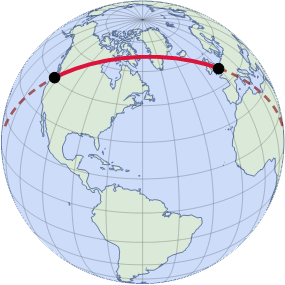
<center>( Image source: https://software.intel.com/sites/default/files/great%20circle.png )</center>

Detailed explanation about **Haversine formula** with code examples can be found on the following pages: [Calculate distance, bearing and more between Latitude/Longitude points](http://www.movable-type.co.uk/scripts/latlong.html) and [Calculate the GPS Distance with the Haversine Formula](http://mathyourlife.github.io/spouting-jibberish/Haversine/Haversine.html).

Once the formula is known, it can be easily written as Python function.

In [ ]:
# Import functions needed from math module
from math import radians, cos, sin, asin, sqrt

# Mean radius of the earth
EARTH_RADIUS = 6371.009

def haversine(p1, p2):
    """ Calculate the great circle distance between two points on Earth
    Returns central angle and distance in km"""
    
    # extract lat and lon from points
    lat1 = get_lat(p1)
    lon1 = get_lon(p1)
    lat2 = get_lat(p2)
    lon2 = get_lon(p2)

    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = [radians(x) for x in [lat1, lon1, lat2, lon2]]

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    central_angle = 2 * asin(sqrt(a))

    # d = r * theta
    km = EARTH_RADIUS * central_angle
    return (km, central_angle)

Test it on the known distances. For example, the distance from Rotterdam centraal to Schiedam Centrum is ≈ 4.09 km, and the distance from Alexandrium to Ahoy is ≈ 8.71 km.

In [ ]:
p = locations[3]        # Rotterdam centraal
q = locations[5]        # Schiedam Centrum

# p = locations[4]        # Ahoy
# q = locations[7]        # Alexandrium

print("From:", p[2], "(",p[0], ",", p[1], ")    to:", q[2], "(",q[0], ",", q[1], ")" )

dist, _ = haversine(p, q)
print("The distance is:", round(dist,4), "km")

Trigonometric functions consume more CPU power than other mathematical functions like addition, subtraction, multiplication, square root. If we allow for minor imprecision in the calculation and don't need the central angle, haversine function can be written as given in the cell below.

In [ ]:
from math import sqrt

def haversine_distance(point1, point2):
    dx = 68.59 * (get_lon(point1) - get_lon(point2))
    dy = 111.195 * (get_lat(point1) - get_lat(point2))
    return sqrt(dx*dx + dy*dy)

Test the new distance function on the same points. What do you conclude?

In [ ]:
p = locations[3]        # Rotterdam centraal
q = locations[5]        # Schiedam Centrum

# p = locations[4]        # Ahoy
# q = locations[7]        # Alexandrium

print("From:", p[2], "(",p[0], ",", p[1], ")    to:", q[2], "(",q[0], ",", q[1], ")" )

dist = haversine_distance(p, q)
print("The distance is:", round(dist,4), "km")

<a id='alltogether'></a>
## The shortest path in Rotterdam

Time to put everything together and find the shortest path for selected points in Rotterdam.

#### The code so far

For ease of use, we repeat the functions explained in the previous sections.

Imports:

In [ ]:
import matplotlib.pyplot as plt

from math import sqrt
from itertools import permutations

Data:

In [ ]:
cities = ((1, 5, "A"), (2, 1, "B"), (9, 10, "C"), (2,10, "D"),
            (5, 4, "E"), (8, 6, "F"), (6, 9, "G"), (10, 1, "H"),
            )

locations = ((51.917362, 4.483990, "Hogeschool Rotterdam"),
                (51.905919, 4.466186, "Euromast"),
                (51.893808, 4.522941, "Stadion Feijenoord"),
                (51.925119, 4.468844, "Rotterdam centraal"),
                (51.882739, 4.488112, "Ahoy"),
                (51.921297, 4.409519, "Schiedam Centrum"),
                (51.953358, 4.440102, "Rotterdam airport"),
                (51.949503, 4.554648, "Alexandrium")
                )

Helper functions:

In [ ]:
def make_round_trip(trip):
    """ appends the first element of the trip as the last """
    return trip[:] + trip[:1]

def get_lat(point):
    return point[0]

def get_lon(point):
    return point[1]

def list_x(all_points):
    return [get_lon(p) for p in all_points]

def list_y(all_points):
    return [get_lat(p) for p in all_points]



Plotting functions:

In [ ]:
def write_text(x, y, text, Xoffset = 0, Yoffset = 0, font_size = 12):
    """ Writes given text (str) at given (x,y) coordinates """
    plt.text(x+Xoffset,y+Yoffset,text, horizontalalignment='center', size=font_size)

## Plotting functions for (x,y) data set - cities
#

def setup_plot(cities):
    """ creates a new plot and sets axes """ 
    plt.subplots(figsize = (8,7))
    x_right = max(cities,key=lambda t: t[0])[0] + 1
    y_top = max(cities,key=lambda t: t[1])[1] + 1
    plt.axis([0, x_right,0, y_top])
        

def plot_cities(cities):
    """ plots given cities; expects each city to have (x,y,"name") """
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.plot(x,y, "bo")

    for city in cities:
        write_text(city[0], city[1], city[2], Xoffset = 0.1, Yoffset = 0.3)

               
def plot_path(trip, round_trip = True):
    """ plots the given trip by connecting cities with lines """
    if round_trip:
        trip = make_round_trip(trip)

    x = [point[0] for point in trip]
    y = [point[1] for point in trip]
    plt.plot(x,y, "g-")

    plt.plot(x[0],y[0], 'rD')

    
## Plotting functions for (lat,lon) data set - locations
#
    
def plot_map(map_file, BBox):
    tsp_map = plt.imread(map_file)
    ax = plt.gca()

    ax.imshow(tsp_map, zorder=0, extent = BBox, aspect='auto')
    
    
def plot_trip(trip, round_trip = True, style='bs-'):
    # make round trip if required
    if round_trip:
        trip = make_round_trip(trip)
        
    # plot points and paths connecting them
    x = list_x(trip)
    y = list_y(trip)
    plt.plot(x,y, style)
    
    # mark starting point
    plt.plot(get_lon(trip[0]), get_lat(trip[0]), 'rD')
    
    # add labels
    for p in trip:
        write_text(get_lon(p), get_lat(p), p[2], Yoffset = 0.001)

TSP-related functions:

In [ ]:
def city_distance(point1, point2):
    """ returns eucledian distance between two points """
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    return sqrt(dy**2 + dx**2)


def haversine_distance(point1, point2):
    """ Calculate the great circle distance between two points on Earth. 
    Doesn't use trigonometric functions."""
    dx = 68.59 * (get_lon(point1) - get_lon(point2))
    dy = 111.195 * (get_lat(point1) - get_lat(point2))
    return sqrt(dx*dx + dy*dy)


def get_trip_length(trip, dist_function = city_distance, round_trip = True):
    """ calculates and returns the trip length using given distance function """
    # if less than two points are given, return special value
    if len(trip) < 2:
        return -1

    # adjust for round trip if needed
    if round_trip:
        trip = make_round_trip(trip)

    # loop through all points, get pairs, sum their distances
    result = 0
    for i in range(len(trip)-1):
        segment_length = dist_function(trip[i], trip[i+1])
        result += segment_length
    return result


def all_trips(cities):
    """ using permutation, create all possible trips (brute force)"""
    return tuple(permutations(cities, r=len(cities)))
    

def list_lengths(trips, dist_function = city_distance, round_trip = True):
    """ create a list holding distance for each of the given trips """
    return [get_trip_length(t, dist_function, round_trip) for t in trips]

Problem-specific constants and files / file loads:

In [ ]:
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)

def load_from_jupyter_attachment():
    # Several libraries are needed to convert different file types
    import io
    import nbformat
    import base64

    # Load this notebook as dictionary
    with io.open("tsp.ipynb", 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)

    # Find the cell containing map and extract the data from the attachment
    data = None
    for cell in nb.cells:
        if 'attachments' in cell:
            if 'map.png' in cell.attachments:
                data = cell.attachments['map.png']['image/png']
                break
    if data:
        return io.BytesIO(base64.b64decode(data))
    return None

#### The shortest path (Rotterdam)

Use the tools available to find the optimal path for the given Rotterdam locations.

In [ ]:
trips = all_trips(locations)
distances = list_lengths(trips, haversine_distance) # IMPORTANT: don't forget to put haversine distance function

best_idx = distances.index(min(distances))
best_trip = trips[best_idx]

print("The shortest trip for the given locations:")
for p in best_trip:
    print("(%s, %s) \t %s" %(p[0],p[1],p[2]))

print("\nTotal distance of the trip is:", round(distances[best_idx],3), "km.")

In [ ]:
# map_BBox = (4.3635, 4.5705, 51.8549, 51.9781) # repeated here if not created before
map_path = load_from_jupyter_attachment()

fig, ax = plt.subplots(figsize = (16,14))
plot_map(map_path, map_BBox)
plot_trip(best_trip)
plt.ion()
plt.show()

<a id='circle'></a>
## Travelling in circles

We mentioned that TSP is NP-hard problem, which means we can only brute-force it for small number of cities. To demonstrate the effectiveness of probabilistic optimisation, we will randomly create N number of cities, and solve it.

For large N, it is also difficult for us, humans, to determine what is the optimal path. But, we can set up a special case. If all cities lie on the circumference of a circle, then the optimal path is an obvious one - the circumference. Fortunately, our computers don't come with that knowledge, so we can use this case to visually estimate how good a solution is.

Let us start by creating a function that will generate N cities on the circumference of a circle.

In [ ]:
from math import sqrt, sin, cos

def generate_cities(n, origin = (5,5), radius = 4):    
    # Convert degrees to radians, n steps form a circle
    step = 6.28319 / n
    # Get (x,y) coordinates and label of a "city" on the circumference of a circle
    cities = [(radius * cos(i*step) + origin[0], radius * sin(i*step) + origin[1], str(i)) for i in range(n)]
    
    return tuple(cities)

Experiment creating `N = 20` cities.

In [ ]:
cities = generate_cities(20)

setup_plot(cities)
plot_cities(cities)
plt.show()

<a id='opt'></a>
## Probabilistic optimisation

Here, we will apply the same approach explained in `probabilistic_optimization.ipynb` reader. First, a random trip is generated. Then we mutate that trip by picking two random points in it, and reverse the path between them. If the new, mutated trip, is of longer lengths (worse), then it is discarded. Otherwise, if its length is shorter (better), then it is kept. The process repeats `steps` times, during which we keep track of the best (the shortest) path found so far.

Three functions are needed:
- `random_trip()` - generates a random trip for given cities,
- `mutate_trip()` - randomly reverses a sub-path of a given trip,
- `solve()` - iterates `step` times, mutating trip and keeping track of the best found so far.

In [ ]:
from random import sample, randint, random

In [ ]:
def random_trip(cities):
    return tuple(sample(cities, len(cities)))

def mutate_trip(trip):
    # pick two points
    a = randint(0,len(trip)-1)
    b = randint(0,len(trip)-1)
    # ensure that a is smaller than b
    if a > b:
        a, b = b, a       
    # reverse path from a to b
    temp_list = list(trip)
    for n in range(a, b+1):
        temp_list[n] = trip[b+a-n]
    return tuple(temp_list)


Start by testing the output of `random_trip()`.

In [ ]:
cities = generate_cities(20)
trip = random_trip(cities)

In [ ]:
print("This is the random trip:")
print("    X\t\tY\tCITY")
for p in trip:
    print("(%.6f, %.6f) \t %s" %(p[0],p[1],p[2]))

print("\n")
print("The length of the trip is:", get_trip_length(trip, dist_function = city_distance))

In [ ]:
setup_plot(cities)
plot_cities(cities)
plot_path(trip)
plt.show()

Unless you are extremely lucky, your random trip contains several intersecting sub-paths and is far from the optimal solution (circumference).

Next, implement `solve()`.

In [ ]:
def solve(first_trip, steps = 100000, survival_chance = 0.01):
    # assume that the first trip is the best trip and find its length
    best_trip = trip = first_trip
    best_trip_length = trip_length = get_trip_length(trip, dist_function = city_distance)
    
    # iterate STEPS times
    for i in range(steps):
        # generate a new, mutated trip and find its length
        new_trip = mutate_trip(trip)
        new_trip_length = get_trip_length(new_trip, dist_function = city_distance)
        # if the new trip is the best one so far, save it
        if new_trip_length < best_trip_length:
            best_trip = new_trip
            best_trip_length = new_trip_length
        # compare the new trip (mutated) with the last trip
        # keep it if it is better OR if it 'survives' a random roll (survival_chance)
        if new_trip_length < trip_length or random() < survival_chance:
            trip = new_trip
            trip_length = new_trip_length
            
    return best_trip

Let us try `solve()` on the random trip from above, but without any survival chance for bad mutations (survival_chance = 0%).

In [ ]:
better_trip = solve(trip, survival_chance = 0)

In [ ]:
setup_plot(cities)
plot_cities(cities)
plot_path(better_trip)
plt.show()

When running the cells above, two outcomes are possible. `solve()` found the optimal path in which case you will see a circle plotted. Alternatively, `solve()` got stuck in a local minimum, returning a solution that is close to the circle, but still has few intersections.

If the solution keeps getting stuck in local optimum, the problem can be overcome by increasing the survival rate for bad mutations, allowing it to "jump out".

Note: if the survival rate is too high, `solve()` will keep generating random paths in which case it is extremely unlikely to ever find the optimal solution.

In [ ]:
best_trip = solve(trip, survival_chance = 0.01)

In [ ]:
setup_plot(cities)
plot_cities(cities)
plot_path(best_trip)
plt.show()

Remember, probabilistic optimisation doesn't guarantee the best (optimal) solution, but it can quickly converge towards the one that is "good enough" - local optimum. If repeated enough times, with different starting values, it is expected to find the optimal solution.

Experiment with more cities, or a different problem setup of your choice.